### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 4s 2ms/step - loss: 0.0058 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00207, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 502us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00207 to 0.00195, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 499us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00195 to 0.00185, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 502us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00185
Epoch 5/150
1712/1712 [==============================] - 1s 498us/step - loss: 0.0010 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00185 to 0.00180, saving model to best_weights.h5
Epoch 6/150
1712/1712 [===

1712/1712 [==============================] - 1s 507us/step - loss: 1.8250e-04 - val_loss: 8.4196e-04

Epoch 00046: val_loss did not improve from 0.00077
Epoch 47/150
1712/1712 [==============================] - 1s 506us/step - loss: 1.7915e-04 - val_loss: 7.8594e-04

Epoch 00047: val_loss did not improve from 0.00077
Epoch 48/150
1712/1712 [==============================] - 1s 508us/step - loss: 1.7412e-04 - val_loss: 7.8997e-04

Epoch 00048: val_loss did not improve from 0.00077
Epoch 49/150
1712/1712 [==============================] - 1s 506us/step - loss: 1.7276e-04 - val_loss: 8.1914e-04

Epoch 00049: val_loss did not improve from 0.00077
Epoch 50/150
1712/1712 [==============================] - 1s 507us/step - loss: 1.6826e-04 - val_loss: 8.2028e-04

Epoch 00050: val_loss did not improve from 0.00077
Epoch 51/150
1712/1712 [==============================] - 1s 504us/step - loss: 1.6872e-04 - val_loss: 7.8281e-04

Epoch 00051: val_loss did not improve from 0.00077
Epoch 52/150
1712

1712/1712 [==============================] - 1s 506us/step - loss: 1.1927e-04 - val_loss: 7.8731e-04

Epoch 00094: val_loss did not improve from 0.00074
Epoch 95/150
1712/1712 [==============================] - 1s 516us/step - loss: 1.1312e-04 - val_loss: 7.7902e-04

Epoch 00095: val_loss did not improve from 0.00074
Epoch 96/150
1712/1712 [==============================] - 1s 513us/step - loss: 1.1190e-04 - val_loss: 7.7062e-04

Epoch 00096: val_loss did not improve from 0.00074
Epoch 97/150
1712/1712 [==============================] - 1s 508us/step - loss: 1.1667e-04 - val_loss: 7.7862e-04

Epoch 00097: val_loss did not improve from 0.00074
Epoch 98/150
1712/1712 [==============================] - 1s 511us/step - loss: 1.1122e-04 - val_loss: 7.8739e-04

Epoch 00098: val_loss did not improve from 0.00074
Epoch 99/150
1712/1712 [==============================] - 1s 508us/step - loss: 1.1335e-04 - val_loss: 8.1416e-04

Epoch 00099: val_loss did not improve from 0.00074
Epoch 100/150
171

1712/1712 [==============================] - 1s 514us/step - loss: 8.4220e-05 - val_loss: 8.2406e-04

Epoch 00143: val_loss did not improve from 0.00074
Epoch 144/150
1712/1712 [==============================] - 1s 511us/step - loss: 8.3115e-05 - val_loss: 7.8455e-04

Epoch 00144: val_loss did not improve from 0.00074
Epoch 145/150
1712/1712 [==============================] - 1s 506us/step - loss: 8.1089e-05 - val_loss: 8.1581e-04

Epoch 00145: val_loss did not improve from 0.00074
Epoch 146/150
1712/1712 [==============================] - 1s 513us/step - loss: 8.1973e-05 - val_loss: 8.0808e-04

Epoch 00146: val_loss did not improve from 0.00074
Epoch 147/150
1712/1712 [==============================] - 1s 498us/step - loss: 8.2304e-05 - val_loss: 8.0725e-04

Epoch 00147: val_loss did not improve from 0.00074
Epoch 148/150
1712/1712 [==============================] - 1s 512us/step - loss: 8.2851e-05 - val_loss: 8.1085e-04

Epoch 00148: val_loss did not improve from 0.00074
Epoch 149/15

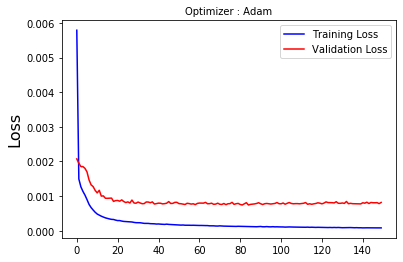

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

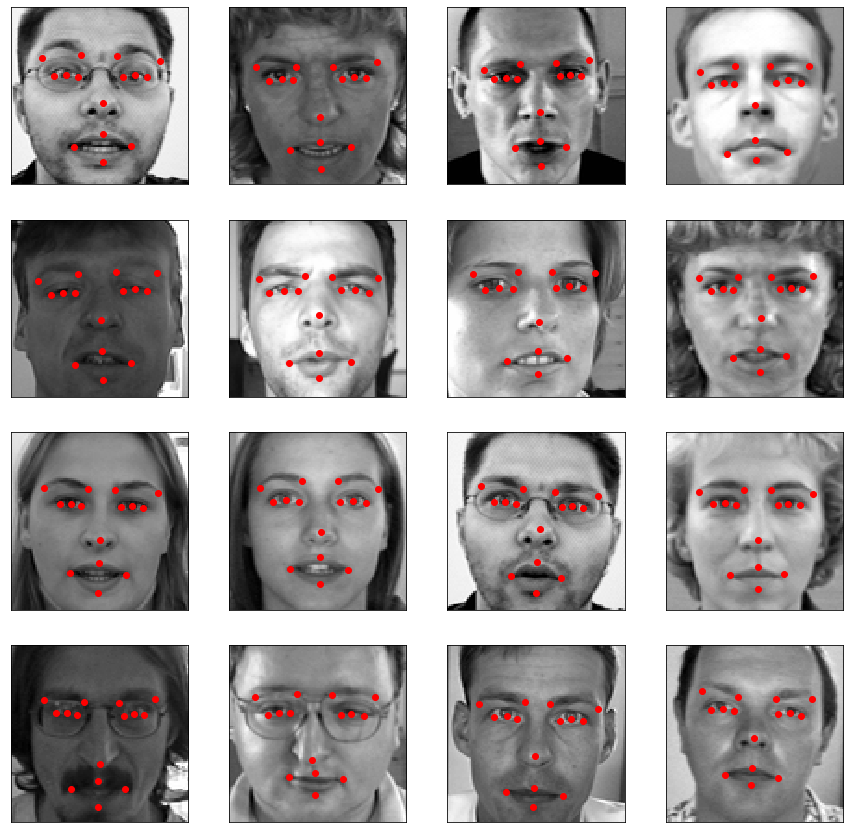

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [14]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

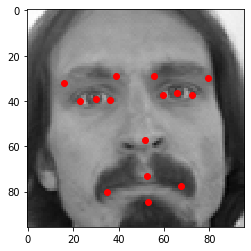

In [15]:
new_image = np.copy(imgs_train[0])
for i in range(96):
    for j in range(96):
        new_image[i][j] =imgs_train[0][i][95-j]
plt.imshow(new_image, cmap='gray')

new_point = np.copy(points_train[0])
for i in range(0,len(new_point),2):
    new_point[i] = -1*new_point[i]
    
for i in range(0,len(new_point),2):
    plt.scatter((new_point[i]+0.5)*96, (new_point[i+1]+0.5)*96, c = 'red')
    plt.imshow(new_image, cmap='gray') 

In [16]:
def img_aug(img, point):
    new_image = np.copy(img)
    for i in range(96):
        for j in range(96):
            new_image[i][j] =img[i][95-j]
    new_point = np.copy(point)
    for i in range(0,len(new_point),2):
        new_point[i] = -1*new_point[i]
    return new_image, new_point

In [17]:
new_img_train=[]
# np.copy(imgs_train)
new_point_train=[]
# np.copy(points_train)
for i in range(imgs_train.shape[0]):
    img = imgs_train[i]
    point = points_train[i]
    new_img, new_point = img_aug(img, point)
#     new_img_train[i] = new_img
    new_img_train.append(new_img)
    #     new_point_train[i] = new_point
    new_point_train.append(new_point)
new_img_train = np.array(new_img_train)
new_point_train = np.array(new_point_train)

In [18]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [19]:
hist_model = model.fit(new_img_train.reshape(-1, 96, 96, 1), 
                       new_point_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 1s 574us/step - loss: 0.0156 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00212, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 511us/step - loss: 0.0017 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00212 to 0.00192, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 501us/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00192 to 0.00190, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 503us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00190
Epoch 5/150
1712/1712 [==============================] - 1s 510us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00190
Epoch 6/150
1712/1712 [==============================] - 1s 5

1712/1712 [==============================] - 1s 507us/step - loss: 3.7866e-04 - val_loss: 0.0012

Epoch 00045: val_loss did not improve from 0.00116
Epoch 46/150
1712/1712 [==============================] - 1s 504us/step - loss: 3.6567e-04 - val_loss: 0.0012

Epoch 00046: val_loss did not improve from 0.00116
Epoch 47/150
1712/1712 [==============================] - 1s 509us/step - loss: 3.7000e-04 - val_loss: 0.0011

Epoch 00047: val_loss improved from 0.00116 to 0.00114, saving model to best_weights.h5
Epoch 48/150
1712/1712 [==============================] - 1s 500us/step - loss: 3.5511e-04 - val_loss: 0.0011

Epoch 00048: val_loss improved from 0.00114 to 0.00113, saving model to best_weights.h5
Epoch 49/150
1712/1712 [==============================] - 1s 503us/step - loss: 3.5407e-04 - val_loss: 0.0012

Epoch 00049: val_loss did not improve from 0.00113
Epoch 50/150
1712/1712 [==============================] - 1s 511us/step - loss: 3.4518e-04 - val_loss: 0.0011

Epoch 00050: val_l

1712/1712 [==============================] - 1s 499us/step - loss: 2.3501e-04 - val_loss: 0.0011

Epoch 00094: val_loss did not improve from 0.00108
Epoch 95/150
1712/1712 [==============================] - 1s 505us/step - loss: 2.2636e-04 - val_loss: 0.0011

Epoch 00095: val_loss did not improve from 0.00108
Epoch 96/150
1712/1712 [==============================] - 1s 506us/step - loss: 2.2944e-04 - val_loss: 0.0011

Epoch 00096: val_loss did not improve from 0.00108
Epoch 97/150
1712/1712 [==============================] - 1s 511us/step - loss: 2.2454e-04 - val_loss: 0.0011

Epoch 00097: val_loss did not improve from 0.00108
Epoch 98/150
1712/1712 [==============================] - 1s 501us/step - loss: 2.2365e-04 - val_loss: 0.0011

Epoch 00098: val_loss did not improve from 0.00108
Epoch 99/150
1712/1712 [==============================] - 1s 515us/step - loss: 2.2465e-04 - val_loss: 0.0011

Epoch 00099: val_loss improved from 0.00108 to 0.00106, saving model to best_weights.h5
Epoc

1712/1712 [==============================] - 1s 509us/step - loss: 1.7620e-04 - val_loss: 0.0011

Epoch 00143: val_loss did not improve from 0.00104
Epoch 144/150
1712/1712 [==============================] - 1s 510us/step - loss: 1.7041e-04 - val_loss: 0.0011

Epoch 00144: val_loss did not improve from 0.00104
Epoch 145/150
1712/1712 [==============================] - 1s 506us/step - loss: 1.7233e-04 - val_loss: 0.0011

Epoch 00145: val_loss did not improve from 0.00104
Epoch 146/150
1712/1712 [==============================] - 1s 511us/step - loss: 1.7129e-04 - val_loss: 0.0011

Epoch 00146: val_loss did not improve from 0.00104
Epoch 147/150
1712/1712 [==============================] - 1s 506us/step - loss: 1.6288e-04 - val_loss: 0.0011

Epoch 00147: val_loss did not improve from 0.00104
Epoch 148/150
1712/1712 [==============================] - 1s 513us/step - loss: 1.6697e-04 - val_loss: 0.0011

Epoch 00148: val_loss did not improve from 0.00104
Epoch 149/150
1712/1712 [===========

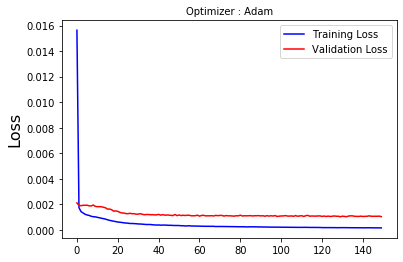

In [20]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')